In [125]:
import io
from PIL import Image
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from pyproj import CRS
import folium
import branca.colormap as cm
import matplotlib.pyplot as plt

In [77]:
MATCH_RESULTS = './data/matched_results_1500_updated.csv'

crs = CRS("EPSG:4326")
porto_lat = 41.1496100 + 0.01
porto_lon = -8.6109900 - 0.019

In [78]:
def obtain_linestring(x):
    try:
        line = shapely.wkt.loads(x)
    except:
        line = None
    return line

def get_coords(geom):
    return list((y, x) for x, y in geom.coords)

In [83]:
df = pd.read_csv(MATCH_RESULTS)
df = df[['id', 'match_geom']]
df['geometry'] = df['match_geom'].apply(obtain_linestring)

In [87]:
gdf = gpd.GeoDataFrame(df, crs=crs)
gdf = gdf.loc[gdf['geometry'] != None, ['id','geometry']]

gdf['lcoord'] = gdf['geometry'].apply(get_coords)

In [89]:
PLOT_LINES = True
PLOT_POINTS = False
points_to_plot = 15
tiles = "CartoDB positron" #"OpenStreetMap" // "CartoDB positron" 

colormap = cm.linear.Set1_06.to_step(points_to_plot).scale(1, points_to_plot)


fmap = folium.Map((porto_lat, porto_lon), zoom_start=14, tiles=tiles, zoom_control=False, attr='AI6128')

for idx, lcoord in enumerate(gdf.loc[:points_to_plot, 'lcoord']):
    feature_group = folium.FeatureGroup(name=f"Line {idx+1}")  
    color = colormap(idx)
    if PLOT_LINES:
        feature_group.add_child(folium.PolyLine(lcoord,color=color,weight=3,tooltip=f"Line {idx+1}"))
    fmap.add_child(feature_group)
    if PLOT_POINTS:
        for p in lcoord:
            feature_group.add_child(folium.Circle(p, radius=1, color=color, fill=True, fill_color=color, fill_opacity=1))
    fmap.add_child(feature_group)    
    

colormap.add_to(fmap)

folium.LayerControl().add_to(fmap)

fmap
# img_data = fmap._to_png(5)
# img = Image.open(io.BytesIO(img_data))
# img.save('task.png')

## Misc

In [74]:
adjusted = pd.read_csv('./data/improved_trip_data.csv')

def get_polyline_coords(data):
    data = eval(data)
    out = [(y,x) for x, y in data]
    return out
adjusted['lcoord'] = adjusted['POLYLINE'].apply(get_polyline_coords)

In [92]:
adjusted.head(2)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,lcoord
0,1372669478620000304,B,NaN,39.0,20000304,1372669478,A,False,"[[-8.622972, 41.150808], [-8.623062, 41.15025]...","[(41.150808, -8.622972), (41.15025, -8.623062)..."
1,1372664473620000409,B,NaN,57.0,20000409,1372664473,A,False,"[[-8.610822, 41.145642], [-8.610453, 41.146164...","[(41.145642, -8.610822), (41.146164, -8.610453..."


In [91]:
gdf.head(2)

,id,geometry,lcoord
0,1372636858620000589,"LINESTRING (-8.61884 41.14175, -8.61868 41.141...","[(41.141753, -8.6188434), (41.141862, -8.61868..."
1,1372637303620000596,"LINESTRING (-8.63986 41.15975, -8.64010 41.159...","[(41.159752, -8.6398592), (41.15979, -8.640096..."


In [107]:
def get_center(lcoord, margin=0.005):

    lats, lons = [], []
    for xy in lcoord[0]:
        lats.append(xy[0])
        lons.append(xy[1])

    lon_min, lon_max = min(lons) - margin, max(lons) + margin
    lat_min, lat_max = min(lats) - margin, max(lats) + margin

    # Calculate center for consistent centering across both codes
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2
    return center_lat, center_lon

In [121]:
trip_id = 1372638303620000112
gdf_lcoord = gdf.loc[gdf['id'] == trip_id, 'lcoord'].values
adj_lcoord = adjusted.loc[adjusted['TRIP_ID'] == trip_id, 'lcoord'].values

center_lat, center_lon = get_center(gdf_lcoord)

In [122]:
fmap = folium.Map((center_lat, center_lon), zoom_start=14, zoom_control=False, attr='AI6128')
feature_group = folium.FeatureGroup(name=f"Line {idx+1}")  
feature_group.add_child(folium.PolyLine(gdf_lcoord,color='black',weight=3,tooltip=f"Line {idx+1}"))
fmap.add_child(feature_group)

img_data = fmap._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save(f'{trip_id}_fmm.png')

In [123]:
fmap = folium.Map((center_lat, center_lon), zoom_start=14, zoom_control=False, attr='AI6128')
feature_group = folium.FeatureGroup(name=f"Line {idx+1}")  
feature_group.add_child(folium.PolyLine(adj_lcoord,color='black',weight=3,tooltip=f"Line {idx+1}"))
fmap.add_child(feature_group)

img_data = fmap._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save(f'{trip_id}_adj.png')

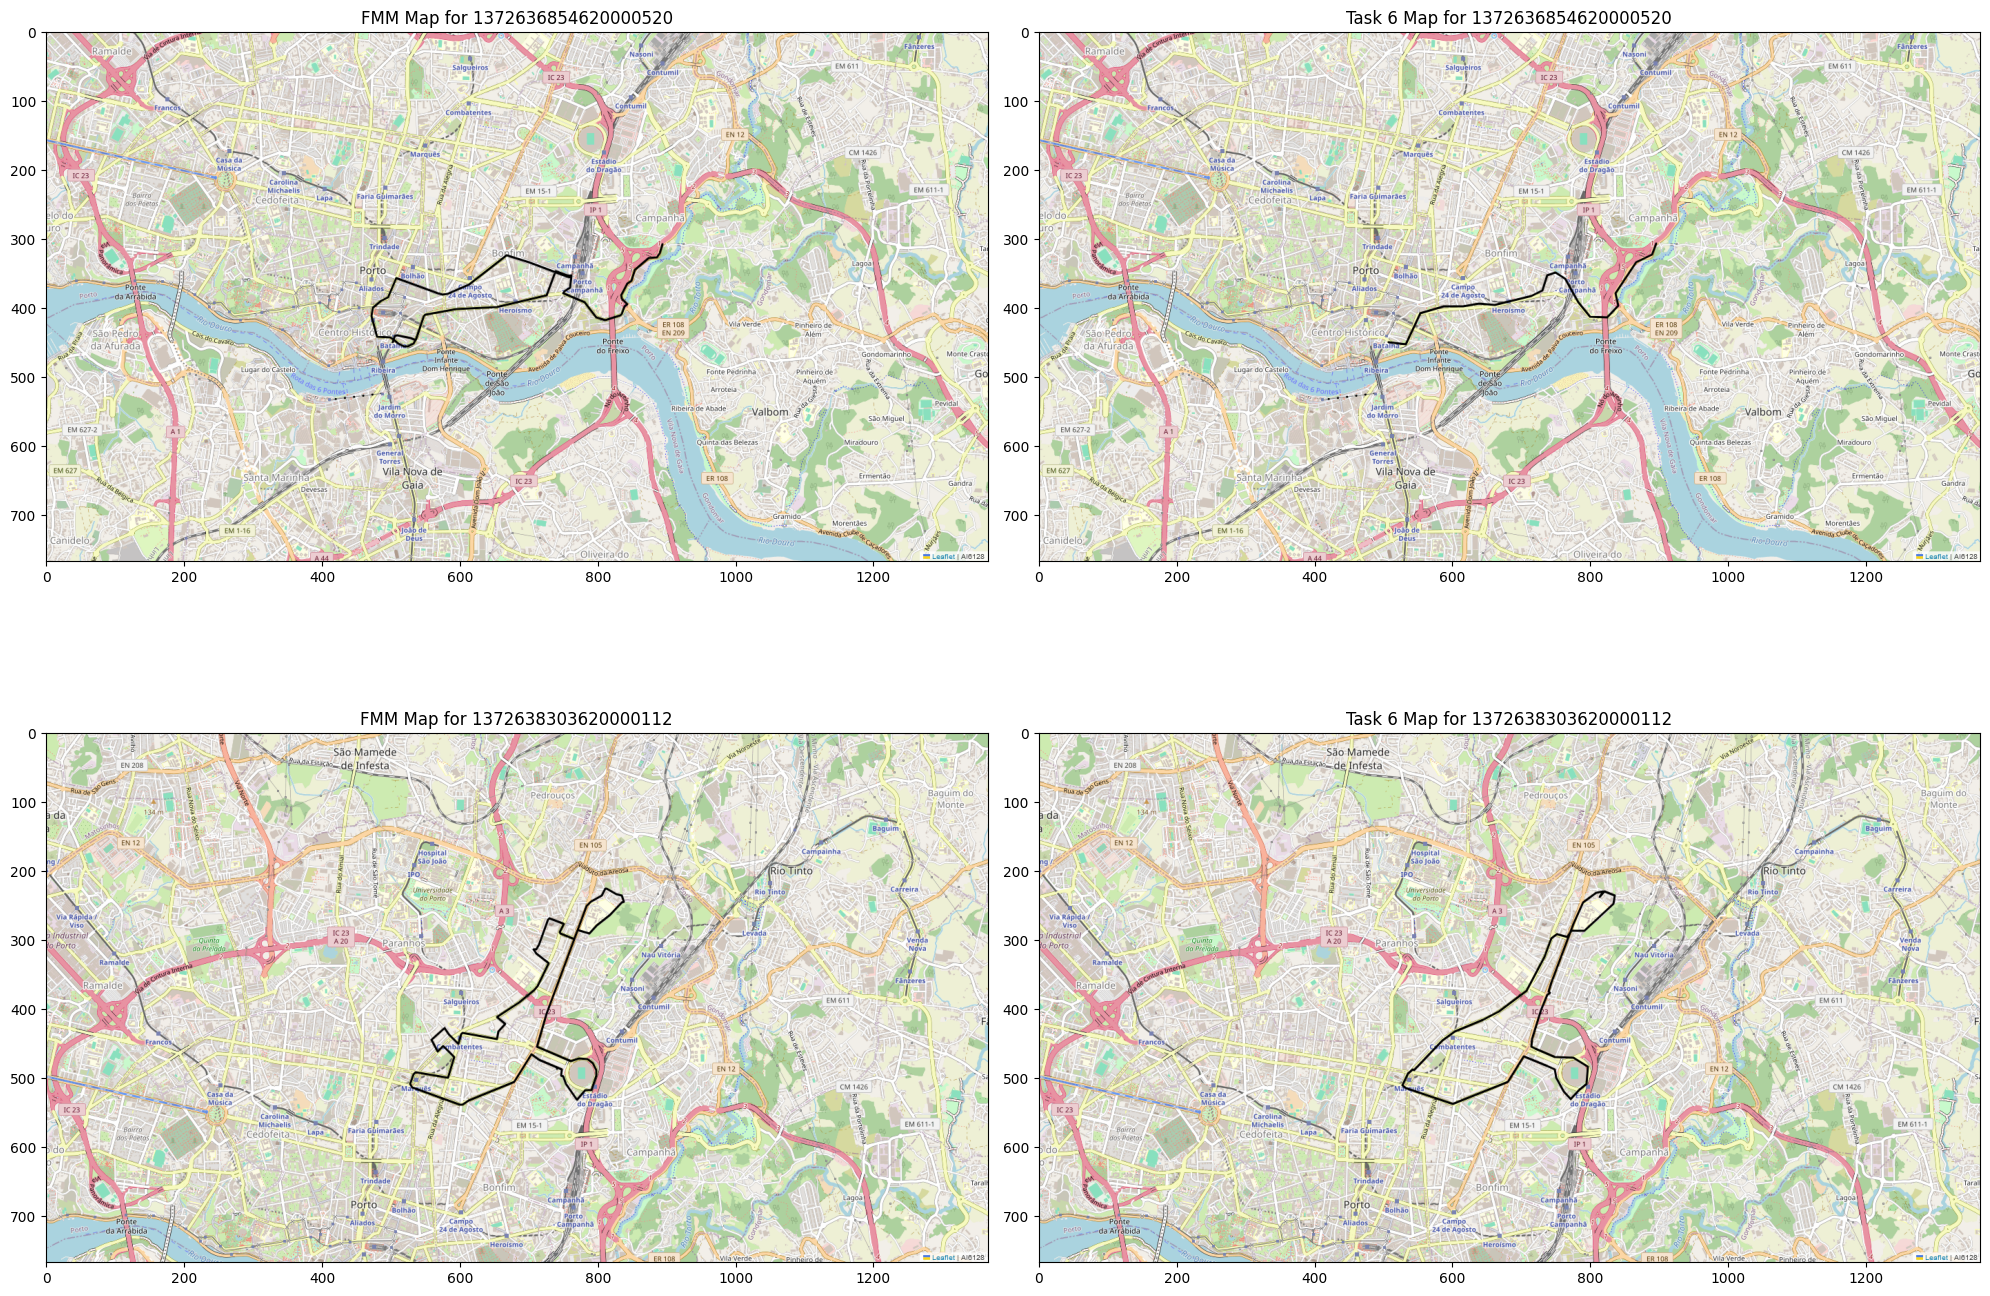

In [145]:
fig, axes = plt.subplots(2,2, figsize=(20, 15))
trip_ids = [1372636854620000520, 1372638303620000112]
for i, trip_id in enumerate(trip_ids):
    fmm_map = plt.imread(f"{trip_id}_fmm.png")
    adj_map = plt.imread(f"{trip_id}_adj.png")
    axes[i,0].imshow(fmm_map)
    axes[i,1].imshow(adj_map)
    axes[i,0].set_title(f"FMM Map for {trip_id}")
    axes[i,1].set_title(f"Task 6 Map for {trip_id}")
plt.tight_layout()
plt.savefig('comparison.png')